# Exp4:  Bert
使用实验三的数据集，在预训练的Bert模型上微调参数。使用微调后的Bert模型做文本分类，并与实验三的RNN模型进行对比分析

https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

In [1]:
import time
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 20211206
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1. 读取数据
由于内存不够，所以随机采样1w条数据来跑。

In [2]:
data_path = "../assignment3/weibo_senti_100k.csv"
df = pd.read_csv(data_path)
df = df.drop_duplicates(subset=['label', 'review'], keep='first')
df = df.drop_duplicates(subset=['review'], keep=False).reset_index(drop=True)
df = df.sample(10000)
df

,label,review
111973,0,公司吃回家吃，白天吃晚上吃，睡觉躺下了还不忘摸黑爬起来吃！！尼玛，我应该买个几箱回来[泪][...
71667,0,我占全了！[晕] //@忽然壹生:我只占半条。你占几条？ @文姬之谈
109175,0,//@杰士邦大侠:究竟那天会发生什么事呢？[抓狂][抓狂][抓狂]好可怕！！！[霹雳][霹雳...
24374,1,"哈哈，狗熊[嘻嘻]。。。坐下，立正，我盯着你呢，你得喂我好吃的，不许玩儿赖,要不然，我怒了啊..."
111472,0,香港的一天，哈哈，吃货的早晨！[哈哈][偷笑][偷笑] 叉烧包真好吃！[偷笑]内个啥，今儿...
...,...,...
7656,1,//@英语情诗表白:小兔子有一颗玻璃心~[鼓掌]
43886,1,[嘻嘻] 好梦
25763,1,[爱你]//@上海时尚前线: [爱你]
48075,1,[good][哈哈] //@挥着翅膀的小菜鸟: 第一张图~找亮点[偷笑]@黄浩俊Howard...


## 2. 查看长度分布 

In [3]:
PRE_TRAINED_MODEL_NAME = 'bert-base-chinese'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [4]:
token_lens = []
for txt in df.review:
    tokens = tokenizer.encode(txt, max_length=256)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


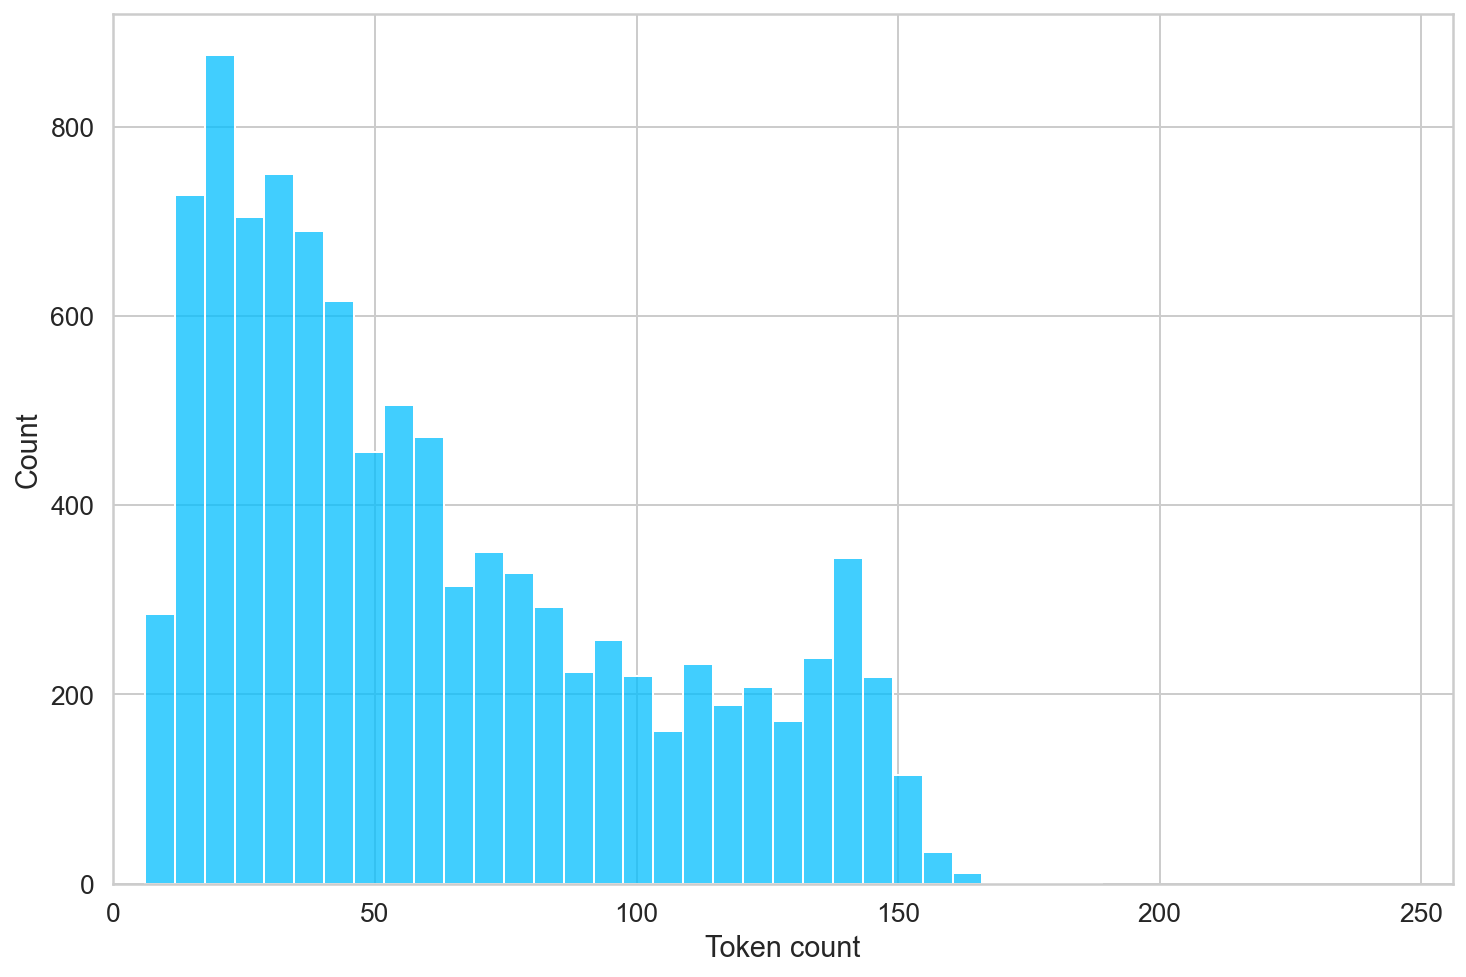

In [5]:
sns.histplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

## 3. 创建数据迭代器

In [6]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

按照9：1的比例划分训练集和测试集（验证集）  
> 因为没怎么调参，直接用的官方推荐参数，所以就没有划分验证集和测试集。

In [7]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)

print(df_train.shape, df_test.shape)

(9000, 2) (1000, 2)


In [8]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.review.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [9]:
MAX_LEN = 160
BATCH_SIZE = 8
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

## 4. 使用Bert模型进行训练

In [10]:
# 解决权重无用警告
from transformers import logging
logging.set_verbosity_error()
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [11]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(output['pooler_output'])
        return self.out(output)

In [12]:
model = SentimentClassifier(n_classes=2)
model = model.to(device)

EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [13]:
def train_epoch(
        model,
        data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)


In [14]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)


In [15]:
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    start = time.time()
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc} time {time.time()-start}')
    test_acc, test_loss = eval_model(
        model,
        test_data_loader,
        loss_fn,
        device,
        len(df_test)
    )
    print(f'TEST  loss {test_loss} accuracy {test_acc} time {time.time()-start}')
    print()

Epoch 1/5
----------
Train loss 0.2681008680904698 accuracy 0.9194444444444445 time 269.7518928050995
TEST  loss 0.20993818299286068 accuracy 0.9480000000000001 time 279.05159425735474

Epoch 2/5
----------
Train loss 0.06110516107519571 accuracy 0.9892222222222222 time 270.4390959739685
TEST  loss 0.06929774211044423 accuracy 0.99 time 279.70084738731384

Epoch 3/5
----------
Train loss 0.026971024015911907 accuracy 0.9954444444444445 time 269.67001247406006
TEST  loss 0.0436958891818067 accuracy 0.992 time 278.9491958618164

Epoch 4/5
----------
Train loss 0.02051986388984369 accuracy 0.9963333333333334 time 269.762131690979
TEST  loss 0.04073083779355511 accuracy 0.993 time 279.01562881469727

Epoch 5/5
----------
Train loss 0.02037587477370592 accuracy 0.9964444444444445 time 269.9329299926758
TEST  loss 0.03868710494894185 accuracy 0.993 time 279.18073773384094



这里的数据只有1w条，并且没有做数据清洗工作，但是对比之前实验3的结果反而还有所提升（之前验证集最好的结果为0.991），这足以说明 Bert 预训练模型的强大之处。